# Probabilistic iLQR 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from scipy.stats import multivariate_normal as mvn
from ocp import *
from costs import *
import pdb
import os
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Simple 2d system

In [2]:
dt = 0.01
m = 1.
A = np.eye(2)
A[0,1] = dt

B = np.zeros((2,1))
B[1] = dt/m

In [3]:
class JumpingRobot():       
    def __init__(self,A,B, dt, m, g = -9.81):
        self.A = A
        self.B = B
        self.Dx = A.shape[0]
        self.Du = B.shape[1]
        self.dt = dt
        self.m = m
        self.g = g
        
    def reset_AB(self, A,B):
        self.A = A
        self.B = B
        
    def compute_matrices(self, x, u):
        return self.A, self.B
        
    def set_init_state(self,x0):
        self.x0 = x0
        
    def step(self, x, u):
        x_next = np.zeros(2)
        
        x_next[0] = x[0] + x[1]*self.dt
        x_next[1] = x[1] + u*self.dt/self.m + self.g*self.dt/m
        return x_next
    
    def rollout(self,us):
        x_cur = self.x0.copy()
        xs = [x_cur]
        T = len(us)
        for i in range(T):
            x_cur = self.step(x_cur, us[i])
            xs += [x_cur]
        return np.array(xs)

In [4]:
sys = JumpingRobot(A, B, dt, m)

In [42]:
x0 = np.array([0.5, 0.])
T = 100
u = np.ones((T, 1))*0

sys.set_init_state(x0)

xs = sys.rollout(u)
x_ref = np.array([0.5,2]) #for 1st order unicycle

#### Define cost parameters 

In [48]:
Q = np.eye(sys.Dx)*0.
Qf = np.eye(sys.Dx)*300
Qf[0] *= 0
#Qf[1,1] *= 10
#Qf[3:,3:] = 0*Qf[3:,3:] 
R = np.eye(sys.Du)*.1



mu = 1e-6

In [49]:
bounds = np.array([[0.2, -100], [0.5, 100]])

In [50]:
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_ref)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningBoundCost = CostModelBound(sys, bounds,weight=1e5 )
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningBoundCost])
    costs += [runningCost]
    
terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost])

costs += [terminalCost]

In [51]:
ilqr = ILQR(sys)
ilqr.set_init_state(x0)
ilqr.set_timestep(T)
ilqr.set_cost(costs)
# ilqr.set_ref(np.zeros((T+1,sys.Dx)))

In [52]:
us = np.zeros((T+1,sys.Du))
sys.set_init_state(x0)
xs = sys.rollout(us[:-1])
ilqr.set_state(xs,us)

18524178.689779475
1.0 990.469040931843
990.469040931843
1.0 900.4682874998134
900.4682874998134
1.0 843.787649670298
843.787649670298
1.0 805.7934344868785
805.7934344868785
1.0 782.3917138755334
782.3917138755334
1.0 764.7910705998461
764.7910705998461
1.0 751.0829777771747
751.0829777771747
1.0 740.0506603179017
740.0506603179017
1.0 730.8031519202481
730.8031519202481
1.0 722.9681166814755
722.9681166814755
1.0 718.7852785473644
718.7852785473644
1.0 717.725109315261
717.725109315261
1.0 717.5482805744207
717.5482805744207
1.0 717.4881735568066
717.4881735568066
1.0 717.4425980542145
717.4425980542145
1.0 717.38078982053
717.38078982053
1.0 717.2025444067933
717.2025444067933
1.0 623064.1521902473
0.8 320404.8806960675
0.6400000000000001 156383.36848835027
0.5120000000000001 73859.01852007202
0.40960000000000013 34398.29714307088
0.32768000000000014 15897.44521404407
0.2621440000000001 7363.292887291208
0.2097152000000001 3507.9427441820017
0.1677721600000001 1818.2265427167672
0.1

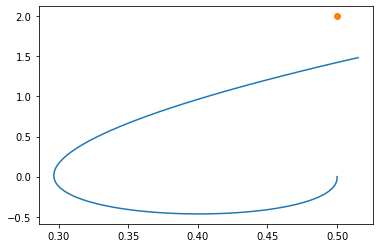

In [53]:
ilqr.solve(50)
# clear_output()
#plt.plot(ilqr.xs[:,1], '-')
plt.plot(ilqr.xs[:,0],ilqr.xs[:,1], '-')
plt.plot(x_ref[0], x_ref[1], 'o')

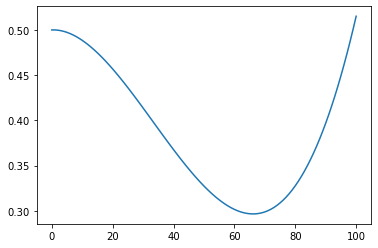

In [54]:
plt.plot(ilqr.xs[:,0])

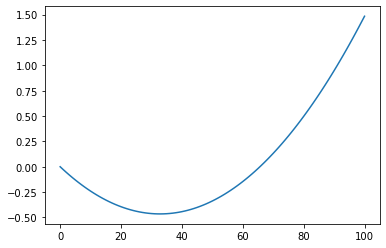

In [55]:
plt.plot(ilqr.xs[:,1])

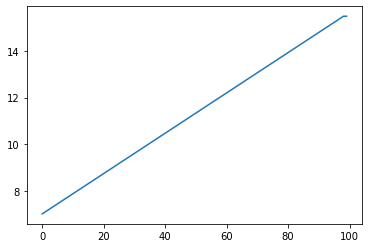

In [56]:
plt.plot(ilqr.us[:-1,0])

#### Use Least Square to compute the distribution

In [50]:
n_samples = 300
_ = ilqr.compute_du_LS()
sample_dxs, sample_dus = ilqr.sample_du(n_samples)
sample_dxs = np.array(sample_dxs).reshape(n_samples, T+1, -1)

sampling


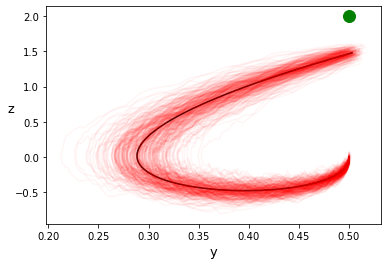

In [54]:
dim = [0,1]
plt.plot(ilqr.xs[:,dim[0]], ilqr.xs[:,dim[1]], 'k')
for i in range(n_samples):
    plt.plot(ilqr.xs[:,dim[0]] + sample_dxs[i,:,dim[0]], ilqr.xs[:,dim[1]]+ sample_dxs[i,:,dim[1]], 'r-', alpha=0.04 )
    #plt.plot(sample_xs[i,-1,0], 'o', alpha=0.3 )
    
plt.plot(x_ref[dim[0]], x_ref[dim[1]], 'go', markersize=12, label = 'Goal')
#plt.title('Trajectory Distribution of Bicopter', fontsize = 16)
plt.xlabel('y', fontsize = 13)
h = plt.ylabel('z', fontsize = 13)
h.set_rotation(0)

    